# Boston house price prediction

In [ ]:
# Import libraries for data manipulation
import pandas as pd
import numpy as np

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import ProbPlot

# Import libraries for building linear regression model
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# Import library for preparing data
from sklearn.model_selection import train_test_split

# Import library for data preprocessing
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

### Load Data

In [15]:
df = pd.read_excel("BostonHousingData.xlsx")
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


Observations:

There are a total of 506 non-null observations in each of the columns. This indicates that there are no missing values in the data.
There are 13 columns in the dataset and every column is of numeric data type.

## Exploratory Data Analysis

In [16]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Univariate analysis

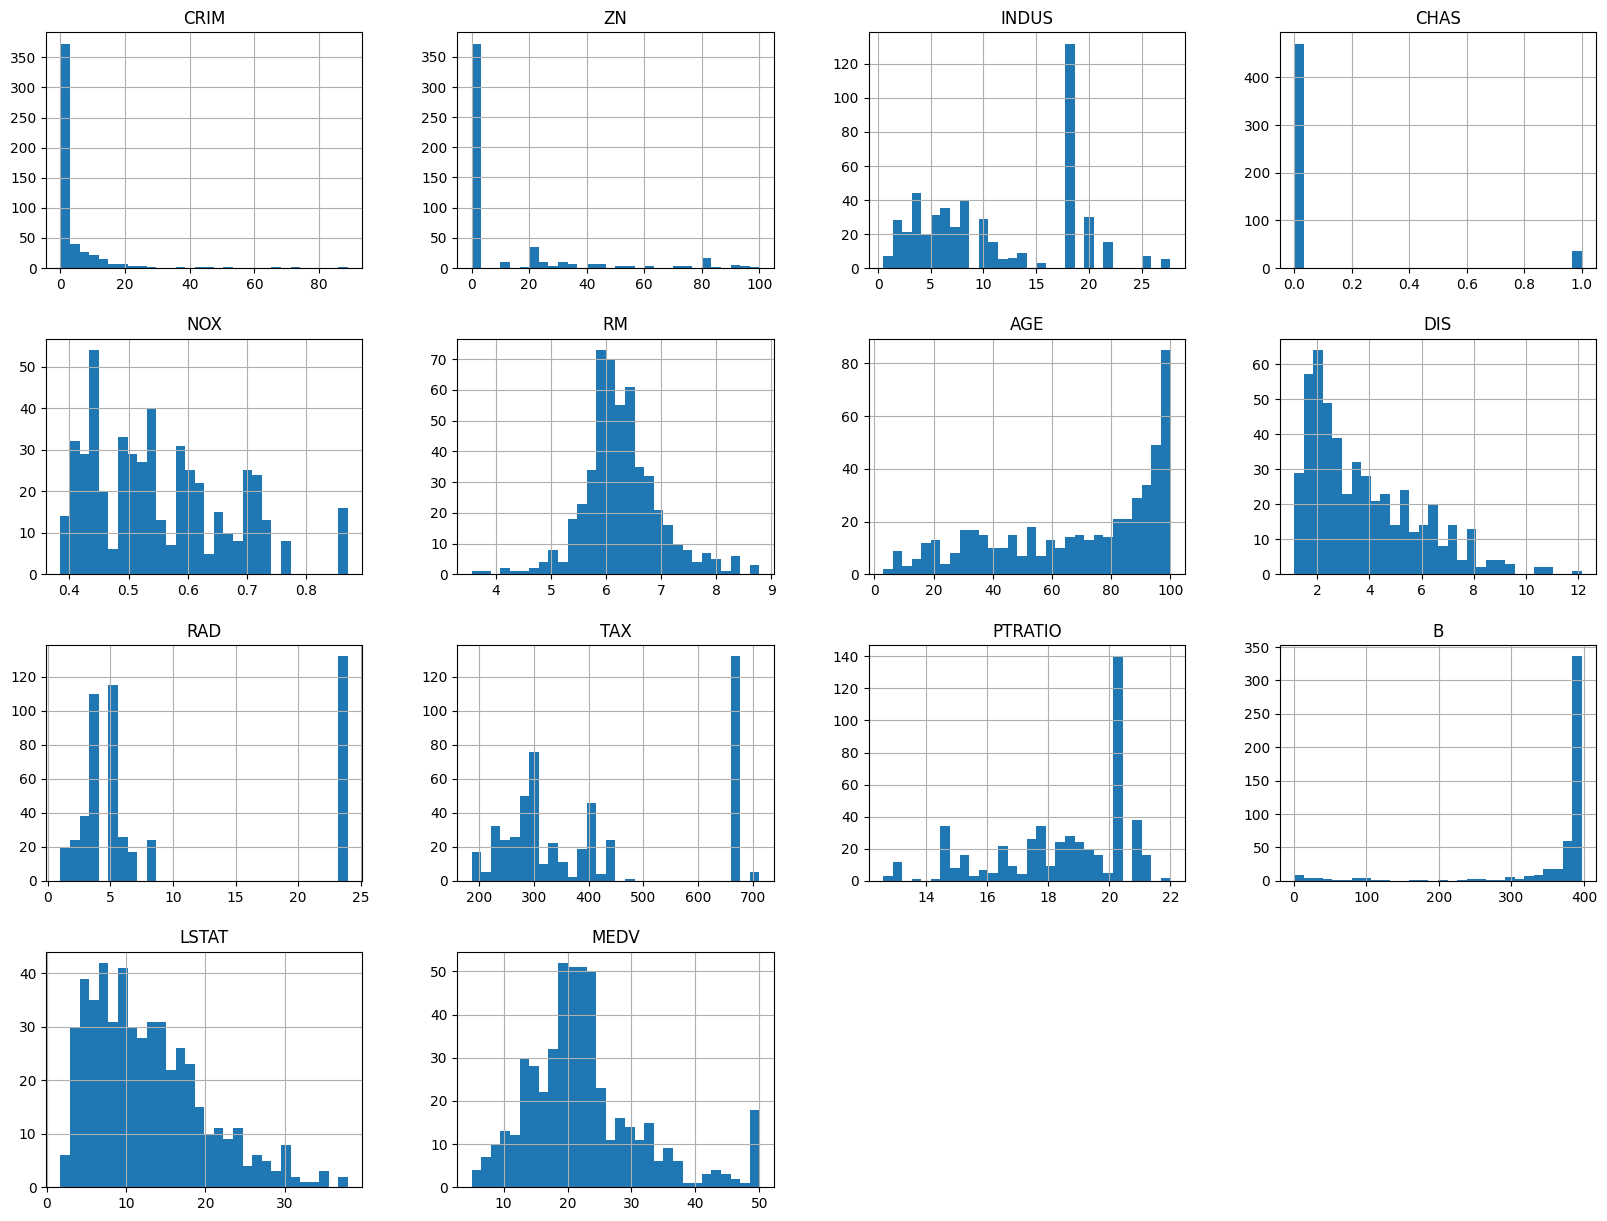

In [18]:
df.hist(bins=30, figsize=(20,15))
plt.show()

MEDV: Median value of owner-occupied homes in 1000 dollars
Slightly skewed. As this is our dependent variable will need to take action to normalize it.
Least squares regression models assume the residuals are normal, and a non-normal dependent variable will produce non-normal residual errors. Therefore, as the dependent variable is sightly skewed, we need to apply a log transformation on the 'MEDV' column and check the distribution of the transformed column.

Note: Using methods like quantile regression and robust regression can use non-normal dependent variables.

<Axes: xlabel='MEDV_log', ylabel='Count'>

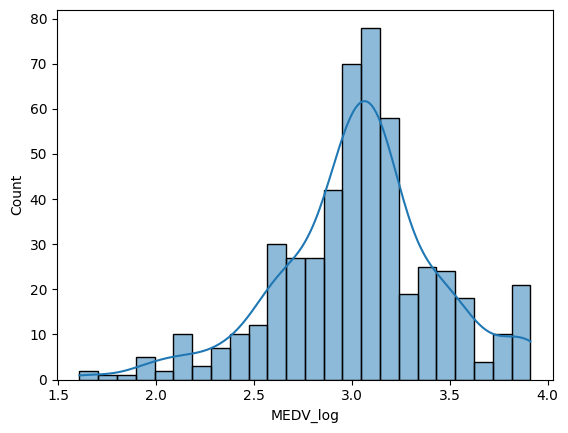

In [7]:
df['MEDV_log'] = np.log(df['MEDV'])
sns.histplot(data = df, x = 'MEDV_log', kde = True)

Observation:

The log-transformation (MEDV_log) appears to have a nearly normal distribution without skew, therefore we can proceed.

### Bivariate Analysis

Check the correlation using heatmap

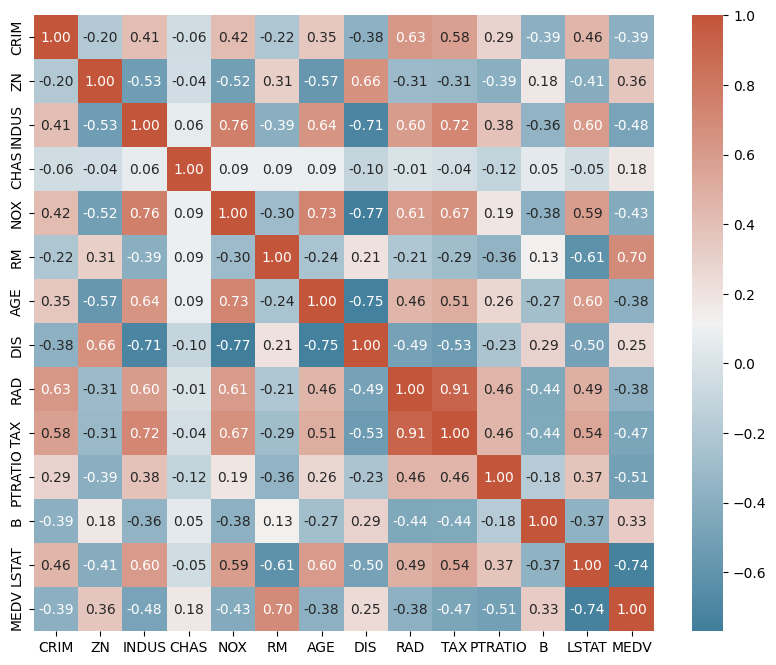

In [19]:
plt.figure(figsize = (10, 8))

cmap = sns.diverging_palette(230, 20, as_cmap = True)

sns.heatmap(df.corr(), annot = True, fmt = '.2f', cmap = cmap)

plt.show()

Observations:

Correlations involving dependent variable:

The highest possitive correlating feature for MEDV_log is RM(average number of rooms),0.63.
This makes sense as more rooms typically indicates a larger home
The highest negative correlating feature for MEDV_log is LSTAT(% lower status of the population),-0.81.
This makes sense as cities often have lower income areas.
It is note worthy that 8/12 of our features have negative correlations with MEDV_log, this means most of them are measuring undesirable factors.

Other strong correlations (>= 0.7 or <= -0.7) not involving our dependent variable:

Positive Correlation between NOX and INDUS, makes sense as more industrial areas would produces more Nitric Oxide
Positive Correlation between NOX and AGE, perhaps indicating that the older areas are more industrialized?
Neggative Correlation between DIS and INDUS, DIS and NOX, DIS and AGE.
Distance to Boston employment centers seems to indicate a more modern area seperate from the older industrial areas that produce more nitric oxide.
Positive Correlation between TAX and INDUS
Very high Positive Correlation between TAX and RAD

### Split the dataset

Split the data into the dependent and independent variables and further split it into train and test set in a ratio of 9:1 for train and test sets.

In [9]:
Y = df['MEDV_log']

X = df.drop(columns = {'MEDV', 'MEDV_log'})

# Add the intercept term
X = sm.add_constant(X)

Intercept Term: allows the regression line to be shifted up or down on the y-axis to better fit the data. The value of the intercept term can be interpreted as the expected value of the dependent variable when all independent variables are set to zero.

In [11]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.10, random_state = 1)

Check for Multicollinearity

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Function to check VIF
def checking_vif(train):
    vif = pd.DataFrame()
    vif["feature"] = train.columns

    # Calculating VIF for each feature
    vif["VIF"] = [
        variance_inflation_factor(train.values, i) for i in range(len(train.columns))
    ]
    return vif


print(checking_vif(X_train))

    feature         VIF
0     const  576.623113
1      CRIM    1.764090
2        ZN    2.411636
3     INDUS    3.905249
4      CHAS    1.069100
5       NOX    4.383297
6        RM    1.951667
7       AGE    3.106329
8       DIS    4.076094
9       RAD    7.415383
10      TAX    9.040709
11  PTRATIO    1.778923
12        B    1.375459
13    LSTAT    2.949307


Observations:

There are two variables with a high VIF - RAD and TAX (greater than 5).
Let's remove TAX as it has the highest VIF values and check the multicollinearity again.

In [13]:
# Create the model after dropping TAX
X_train = X_train.drop(columns = 'TAX')

# Check for VIF
print(checking_vif(X_train))

    feature         VIF
0     const  571.121327
1      CRIM    1.763514
2        ZN    2.259899
3     INDUS    3.140632
4      CHAS    1.052977
5       NOX    4.362991
6        RM    1.943733
7       AGE    3.099190
8       DIS    4.075515
9       RAD    2.817402
10  PTRATIO    1.764245
11        B    1.375158
12    LSTAT    2.949012


VIF is less than 5 for all the independent variables, and we can assume that multicollinearity has been removed between the variables.

## Model Building

### Linear Regression Model1